__Sales Forecasting Using ARIMA Model__  

This jupyter notebook brings a forecast using ARIMA model and walk forward.  
Through the analysis, we'll prove that the time series is stationary and autocorrelated.  
The data will be split 50/50 train/test.  
Both the results and the residuals will be evaluated.

## Importing Necessary Packages

In [1]:
pip install statsmodels==0.13.2 pandas==1.5.3

  Using cached pandas-1.5.3-cp39-cp39-win_amd64.whl.metadata (12 kB)
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.1 MB 3.3 MB/s eta 0:00:03
   - -------------------------------------- 0.3/9.1 MB 4.8 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/9.1 MB 6.5 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/9.1 MB 8.6 MB/s eta 0:00:01
   ------- -------------------------------- 1.7/9.1 MB 9.9 MB/s eta 0:00:01
   -------- ------------------------------- 1.9/9.1 MB 8.9 MB/s eta 0:00:01
   --------- ------------------------------ 2.1/9.1 MB 8.5 MB/s eta 0:00:01
   ----------- ---------------------------- 2.7/9.1 MB 9.7 MB/s eta 0:00:01
   ------------- -------------------------- 3.0/9.1 MB 10.2 MB/s eta 0:00:01
   --------------- ------------------------ 3.5/9.1 MB 9.8 MB/s eta 0:00:01
   ---------------- ----------------------- 3.9/9.1 MB 9.9 MB/s eta 0:00:01
   ------------------- --

In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
import pandas.testing as tm

from numpy import sqrt
from sklearn.metrics import mean_squared_error

In [17]:
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Uploading Database

In [18]:
file_path = '.\champagne_sales.csv'

In [19]:
series = pd.read_csv(file_path, header = 0, index_col = 0, parse_dates = True).squeeze('columns')

## EDA

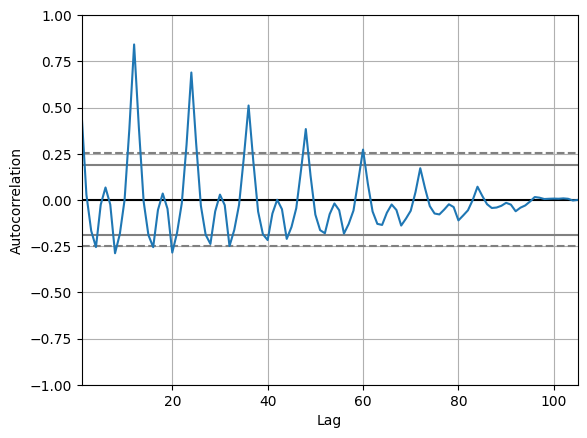

In [20]:
# Autocorrelation plot 
autocorrelation_plot(series)
plt.show()

The series are showing a strong correlation until, aproximately, the 15th lag. After that, the correlation decreases.

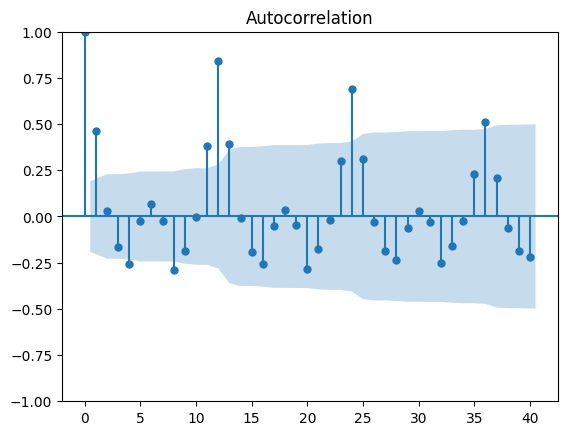

In [21]:
# Another autocorrelation plot

plot_acf(series, lags=40)
plt.show()

Reaffirming what the previous autocorrelation graph has shown, the higher correlation goes until the 12th-15th lag.

## ARIMA Model

ARIMA, which stands for AutoRegressive Integrated Moving Average, is a class of statistical models used for analyzing and forecasting time series data. Its notation is: ARIMA(p, d, q)  

* p: Number of lag observations included in the model (AR part).
* d: Number of times that the raw observations are differenced (I part).
* q: Size of the moving average window (MA part).
  
In order to work with ARIMA, the time series must be stationary and autocorrelated. 
We've already proven that our series has correlation, through the last 2 graphs. 

In [22]:
series = pd.Series(series)

In [23]:
# In this step, we will apply differentiation to our non-stationary time series data to transform it into a stationary series.

model = ARIMA(series, order = (7, 1, 1))

In [24]:
model_fit = model.fit()

In [25]:
# Summary

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -945.843
Date:                Wed, 10 Jul 2024   AIC                           1909.686
Time:                        00:22:19   BIC                           1933.485
Sample:                    01-01-1964   HQIC                          1919.328
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7817      0.304     -2.572      0.010      -1.377      -0.186
ar.L2         -0.5195      0.170     -3.047      0.002      -0.854      -0.185
ar.L3         -0.3445      0.257     -1.339      0.1

In [26]:
# Plot Residuals

residuals = DataFrame(model_fit.resid)

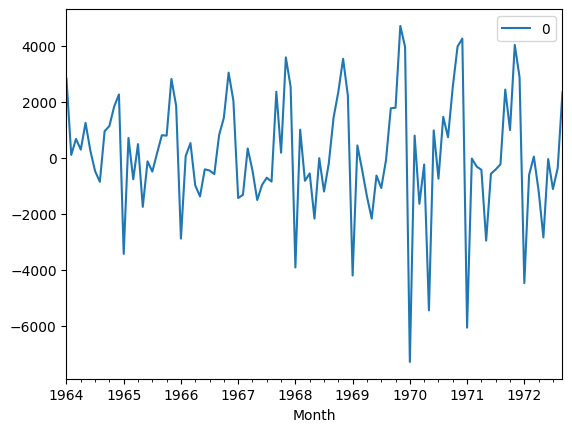

In [27]:
residuals.plot()
plt.show()

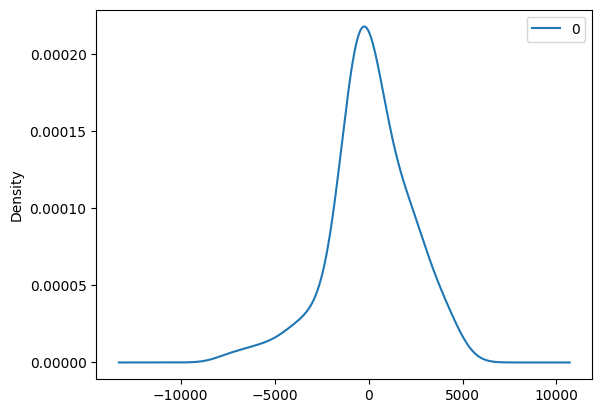

In [28]:
# Residuals Density Graph

residuals.plot(kind='kde')
plt.show()

In [29]:
# Residuals Descriptive Statistics

print(residuals.describe())

                 0
count   105.000000
mean     84.218730
std    2138.977928
min   -7289.202724
25%    -853.011676
50%     -29.302189
75%    1427.330814
max    4706.374721


## Predicting Data with ARIMA Using Walk Forward

Train vs Test Split

In [30]:
# X receives the series data

X = series.values
X = X.astype('float32')

In [31]:
# Separating 50% of the data for train/test

size = int(len(X) * 0.50)

In [32]:
# Splitting train/test

train = X[0:size]
test =  X[size:]

In [33]:
# Creating History variable

history = [x for x in train]

In [34]:
# Creating Prediction List

predictions = list()

In [35]:
# Creating differentiation function

def difference(dataset, interval=1):
  diff = list() 
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

# Creating function to reverse differentiation

def inverse_difference(history, predict, interval=1):
  return predict + history[-interval]

In [36]:
# Starting the Walk-Forward
for t in range(len(test)):
  
    # difference data
    year_months = 12
    diff = difference(history, year_months)
    
    # Creates an ARIMA model with history data
    model = ARIMA(diff, order=(1,1,1))
    
    # Training the ARIMA model
    model_fit = model.fit()
    
    # Variable value_predict receives the value predicted by the model
    value_predict = model_fit.forecast()[0]
  
    # value_predict receives the reversed value (original scale)
    value_predict = inverse_difference(history, value_predict, year_months)
     
    # Adds the value_predict to the predictions list
    predictions.append(value_predict)
    
    # Variable real_value receives the test's real value
    real_value = test[t]
    
    # Adds the real_value to history variable
    history.append(real_value)
    
    # Prints predicted value and real value
    print('Predicted Value = %.3f, Expected Value = %3.f' % (value_predict, real_value))

Predicted Value = 5129.641, Expected Value = 4647
Predicted Value = 5031.196, Expected Value = 4753
Predicted Value = 4133.285, Expected Value = 3965
Predicted Value = 2095.321, Expected Value = 1723
Predicted Value = 5216.271, Expected Value = 5048
Predicted Value = 5866.317, Expected Value = 6922
Predicted Value = 8591.061, Expected Value = 9858
Predicted Value = 11028.649, Expected Value = 11331
Predicted Value = 4090.352, Expected Value = 4016
Predicted Value = 4767.109, Expected Value = 3957
Predicted Value = 4656.326, Expected Value = 4510
Predicted Value = 4577.708, Expected Value = 4276
Predicted Value = 5108.656, Expected Value = 4968
Predicted Value = 5202.831, Expected Value = 4677
Predicted Value = 4423.982, Expected Value = 3523
Predicted Value = 2162.388, Expected Value = 1821
Predicted Value = 5463.233, Expected Value = 5222
Predicted Value = 7331.345, Expected Value = 6872
Predicted Value = 10258.651, Expected Value = 10803
Predicted Value = 11732.476, Expected Value = 

In [37]:
# Evaluating the results

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 845.226


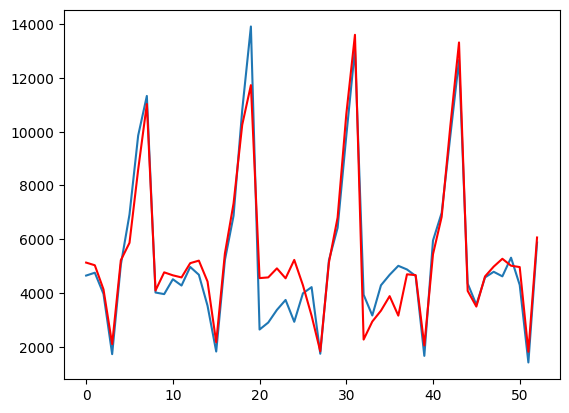

In [38]:
# Plot forecasts against actual outcomes 

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Analyzing Residuals


__Residual Error = Expected Value − Predicted Value__  

  Residual errors are errors in time series forecasts.
  An analysis of the errors can suggest improvements in the model.


In [49]:
# Residual errors

residuals_errors = [test[i] - predictions[i] for i in range(len(test))]

In [50]:
# Transforming residuals into a dataframe
residuals_errors = pd.DataFrame(residuals)

In [51]:
residuals_errors.head()

,0
0,-482.640659
1,-278.195726
2,-168.285472
3,-372.320949
4,-168.270654


In [52]:
residuals_errors.describe()

,0
count,53.000000
mean,-110.614045
std,845.975755
min,-2302.775432
25%,-482.640659
50%,-186.564691
75%,225.681967
max,2183.523538


The negative mean shows the residuals errors are biased towards lower results, compared to the actual data.

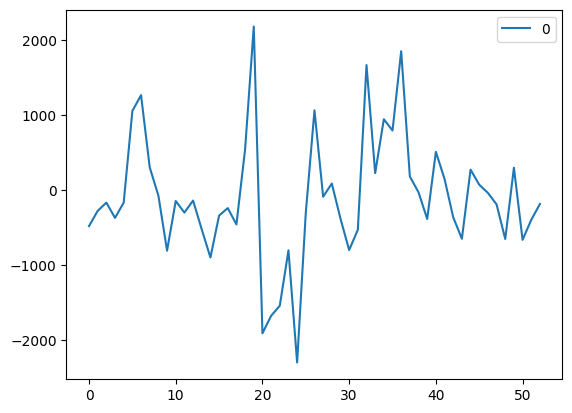

In [53]:
# Plot residuals

residuals_errors.plot()
plt.show()

The graph doesn't show a trend neither a sazonality, meaning the model captured the correlation of the data.

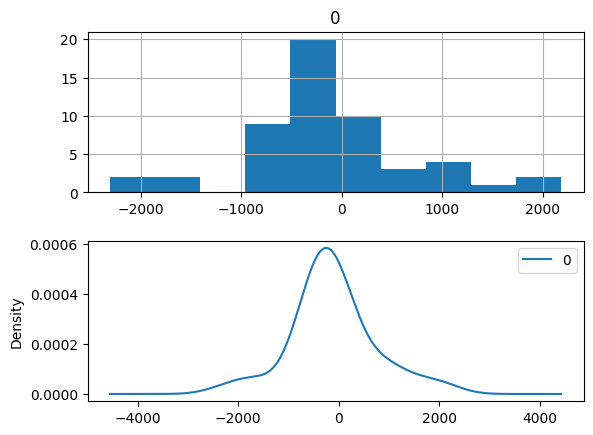

In [54]:
# Plot Histogram

plt.figure()
plt.subplot(211)
residuals_errors.hist(ax=plt.gca())

plt.subplot(212)
residuals_errors.plot(kind='kde', ax=plt.gca())
plt.show()
     

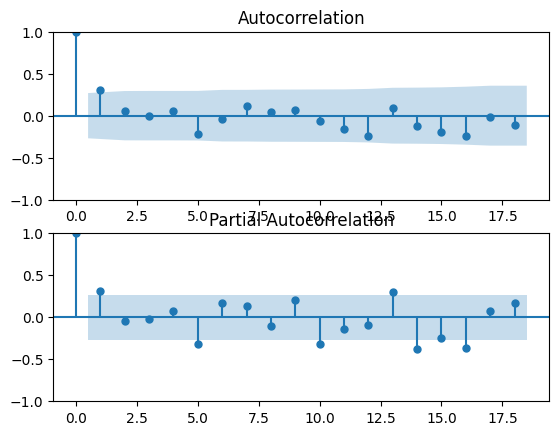

In [55]:
# Autocorrelation

plt.figure() 
plt.subplot(211)
plot_acf(residuals_errors, ax=plt.gca())


plt.subplot(212)
plot_pacf(residuals_errors, ax=plt.gca())
plt.show()

The graph shows there's an autocorrelation, but it's not statistically significant.